In [2]:
import os
import cv2
import numpy
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

# Generator Section

In [3]:
def res_block(ip):
    res_model = Conv2D(64, (3,3), padding= "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding= "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

# Descriminator Section


In [5]:
def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3), strides = strides, padding = "same")(ip)
    
    if bn:
        disc_model  = BatchNormalization(momentum=0.8)(disc_model)
    
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    
    return disc_model

In [6]:
def create_disc(disc_ip):
    
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

# VGG19

In [7]:
from keras.applications import VGG19

In [8]:
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    
    return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

# Combined Model

In [9]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# Training it with some demo images:

In [54]:
n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   

hr_list = os.listdir("data/hr_images")[:n]
hr_images = []
for img in lr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

In [55]:
import numpy as np

In [56]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

# Checking it out with few images

In [57]:
import random
import numpy as np

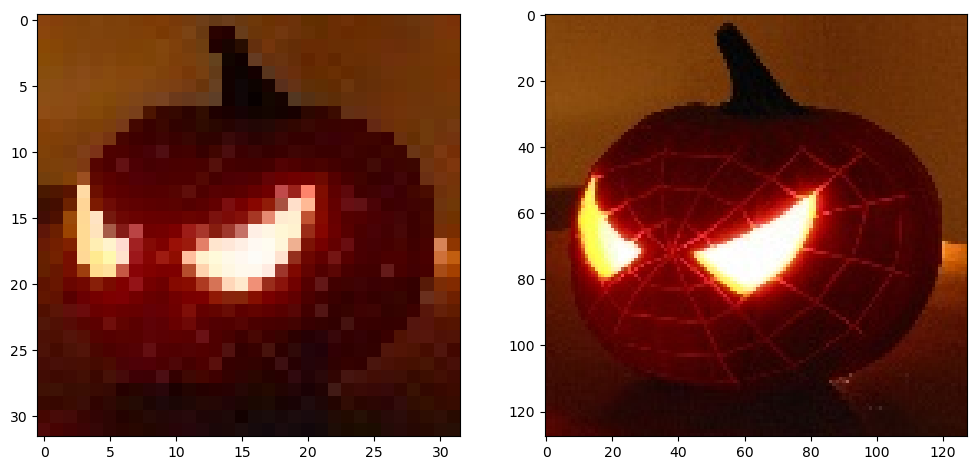

In [58]:
image_number = random.randint(0,len(lr_images)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32,32,3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number],(128,128,3)))
plt.show()

lr_images = lr_images / 255.
hr_images = hr_images / 255.


# train and test split

In [59]:
lr_train,lr_test,hr_train,hr_test  = train_test_split(lr_images, hr_images,
                                                     test_size=0.33, random_state=42)

In [60]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape = lr_shape)
hr_ip = Input(shape = hr_shape)

In [61]:
generator = create_gen(lr_ip, num_res_block=16)
generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 32, 32, 64)           15616     ['input_4[0][0]']             
                                                                                                  
 p_re_lu_19 (PReLU)          (None, 32, 32, 64)           64        ['conv2d_45[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_19[0][0]']          
                                                                                            

                                                                    ']                            
                                                                                                  
 conv2d_55 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_24[0][0]']          
                                                                                                  
 batch_normalization_49 (Ba  (None, 32, 32, 64)           256       ['conv2d_55[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_21 (Add)                (None, 32, 32, 64)           0         ['add_20[0][0]',              
                                                                     'batch_normalization_49[0][0]
                                                                    ']                            
          

                                                                                                  
 p_re_lu_29 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_58[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_65 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_29[0][0]']          
                                                                                                  
 batch_normalization_59 (Ba  (None, 32, 32, 64)           256       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_26 (Add)                (None, 32, 32, 64)           0         ['add_25[0][0]',              
          

 batch_normalization_68 (Ba  (None, 32, 32, 64)           256       ['conv2d_74[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_34 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_68[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_75 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_34[0][0]']          
                                                                                                  
 batch_normalization_69 (Ba  (None, 32, 32, 64)           256       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

In [62]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_82 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_73 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                           

In [63]:
vgg = build_vgg((128,128,3))
print(vgg.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [64]:
gan_model = create_comb(generator,discriminator,vgg,lr_ip,hr_ip)

In [65]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model_4 (Functional)        (None, 128, 128, 3)          2044291   ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_5 (Functional)        (None, 1)                    3824928   ['model_4[0][0]']             
                                                          1                                 

In [79]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

epochs = 10

for e in range(epochs):
    fake_labels = np.zeros((batch_size,1))
    real_labels = np.ones((batch_size,1))
    
    g_losses = []
    d_losses = []

In [80]:
for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_labels)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_labels, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses=np.append(d_losses,d_loss)
        g_losses=np.append(g_losses,g_loss)
        g_losses = np.array(g_losses)
        d_losses = np.array(d_losses)
    
        #Calculate the average losses for generator and discriminator
        g_loss = np.sum(g_losses, axis=0) / len(g_losses)
        d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
        #Report the progress during training. 
        print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

        if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
            #Save the generator after every n epochs (Usually 10 epochs)
            generator.save("trained"+ str(e+1) +".h5")

  0%|                                                                                         | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step
epoch: 10 g_loss: 3.9189899325720035e-06 d_loss: 0.5


  0%|                                                                               | 1/3350 [00:01<1:40:29,  1.80s/it]

1/1 [==============================] - 0s 47ms/step
epoch: 10 g_loss: 3.6811619565924047e-06 d_loss: 0.5000000000001255


  0%|                                                                               | 2/3350 [00:03<1:22:26,  1.48s/it]

1/1 [==============================] - 0s 37ms/step
epoch: 10 g_loss: 4.530960950432927e-06 d_loss: 0.5000000000003133


  0%|                                                                               | 3/3350 [00:04<1:15:32,  1.35s/it]

1/1 [==============================] - 0s 39ms/step
epoch: 10 g_loss: 4.9184756676368124e-06 d_loss: 0.500000000000235


  0%|                                                                               | 4/3350 [00:05<1:12:08,  1.29s/it]

1/1 [==============================] - 0s 36ms/step
epoch: 10 g_loss: 4.046206981911382e-06 d_loss: 0.5000000000001881


  0%|                                                                               | 5/3350 [00:06<1:10:00,  1.26s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 3.499573381304799e-06 d_loss: 0.5000000570366916


  0%|▏                                                                              | 6/3350 [00:07<1:08:11,  1.22s/it]

1/1 [==============================] - 0s 31ms/step
epoch: 10 g_loss: 3.6114761639640036e-06 d_loss: 0.5000000488898769


  0%|▏                                                                              | 7/3350 [00:08<1:07:08,  1.21s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 3.725270090626509e-06 d_loss: 0.5000000427786423


  0%|▏                                                                              | 8/3350 [00:10<1:06:12,  1.19s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.056899873224514e-06 d_loss: 0.5000000380254598


  0%|▏                                                                              | 9/3350 [00:11<1:06:06,  1.19s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 3.858017976199335e-06 d_loss: 0.5000000342229138


  0%|▏                                                                             | 10/3350 [00:12<1:05:37,  1.18s/it]

1/1 [==============================] - 0s 35ms/step
epoch: 10 g_loss: 4.379814795770058e-06 d_loss: 0.5000000311117485


  0%|▎                                                                             | 11/3350 [00:13<1:05:26,  1.18s/it]

1/1 [==============================] - 0s 36ms/step
epoch: 10 g_loss: 4.581562526103274e-06 d_loss: 0.5000000285191065


  0%|▎                                                                             | 12/3350 [00:14<1:06:12,  1.19s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.498036087870088e-06 d_loss: 0.5000000263253291


  0%|▎                                                                             | 13/3350 [00:16<1:05:33,  1.18s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.216552298430543e-06 d_loss: 0.5000000244449485


  0%|▎                                                                             | 14/3350 [00:17<1:05:29,  1.18s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.077967813979437e-06 d_loss: 0.5000000228152852


  0%|▎                                                                             | 15/3350 [00:18<1:06:34,  1.20s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.1259795828807455e-06 d_loss: 0.5000000213893299


  0%|▎                                                                             | 16/3350 [00:19<1:06:09,  1.19s/it]

1/1 [==============================] - 0s 40ms/step
epoch: 10 g_loss: 4.056691319179021e-06 d_loss: 0.500000020131134


  1%|▍                                                                             | 17/3350 [00:20<1:06:49,  1.20s/it]

1/1 [==============================] - 0s 42ms/step
epoch: 10 g_loss: 3.930399224651006e-06 d_loss: 0.5000000190127376


  1%|▍                                                                             | 18/3350 [00:22<1:07:02,  1.21s/it]

1/1 [==============================] - 0s 41ms/step
epoch: 10 g_loss: 3.763321779771152e-06 d_loss: 0.5000000180120673


  1%|▍                                                                             | 19/3350 [00:23<1:07:02,  1.21s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.172255242451684e-06 d_loss: 0.5000000171114639


  1%|▍                                                                             | 20/3350 [00:24<1:06:40,  1.20s/it]

1/1 [==============================] - 0s 39ms/step
epoch: 10 g_loss: 4.3339685042892165e-06 d_loss: 0.5000000162966323


  1%|▍                                                                             | 21/3350 [00:25<1:06:19,  1.20s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.204272580016715e-06 d_loss: 0.5000000155558763


  1%|▌                                                                             | 22/3350 [00:26<1:05:41,  1.18s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.387096176426143e-06 d_loss: 0.5000000148795338


  1%|▌                                                                             | 23/3350 [00:27<1:05:15,  1.18s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.328966191735617e-06 d_loss: 0.5000000142595532


  1%|▌                                                                             | 24/3350 [00:29<1:04:48,  1.17s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.561863895560236e-06 d_loss: 0.5000000136891711


  1%|▌                                                                             | 25/3350 [00:30<1:04:34,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.445158339194677e-06 d_loss: 0.5000000131632769


  1%|▌                                                                             | 26/3350 [00:31<1:04:23,  1.16s/it]

1/1 [==============================] - 0s 31ms/step
epoch: 10 g_loss: 4.4167962174570776e-06 d_loss: 0.5000000126757481


  1%|▋                                                                             | 27/3350 [00:32<1:04:20,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.452895822737446e-06 d_loss: 0.5000000122230429


  1%|▋                                                                             | 28/3350 [00:33<1:04:05,  1.16s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.4525788878453225e-06 d_loss: 0.5000000118015587


  1%|▋                                                                             | 29/3350 [00:34<1:03:55,  1.15s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.348000188277486e-06 d_loss: 0.5000000114081735


  1%|▋                                                                             | 30/3350 [00:36<1:04:03,  1.16s/it]

1/1 [==============================] - 0s 36ms/step
epoch: 10 g_loss: 4.2686493715806256e-06 d_loss: 0.5000000110401679


  1%|▋                                                                             | 31/3350 [00:37<1:04:23,  1.16s/it]

1/1 [==============================] - 0s 36ms/step
epoch: 10 g_loss: 4.1911238550795815e-06 d_loss: 0.5000000106951821


  1%|▋                                                                             | 32/3350 [00:38<1:04:28,  1.17s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.18951606379227e-06 d_loss: 0.5000000103710857


  1%|▊                                                                             | 33/3350 [00:39<1:04:23,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.20329877048222e-06 d_loss: 0.5000000100676038


  1%|▊                                                                             | 34/3350 [00:40<1:04:11,  1.16s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.1794839733354045e-06 d_loss: 0.5000000103107256


  1%|▊                                                                             | 35/3350 [00:41<1:04:04,  1.16s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.09310148086206e-06 d_loss: 0.5000000103555049


  1%|▊                                                                             | 36/3350 [00:43<1:03:54,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.249647920337216e-06 d_loss: 0.5000000100756263


  1%|▊                                                                             | 37/3350 [00:44<1:03:53,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.294404997034163e-06 d_loss: 0.5000000098104783


  1%|▉                                                                             | 38/3350 [00:45<1:03:42,  1.15s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.289850766944698e-06 d_loss: 0.5000000095589276


  1%|▉                                                                             | 39/3350 [00:46<1:03:45,  1.16s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.285723552754917e-06 d_loss: 0.5000000093199557


  1%|▉                                                                             | 40/3350 [00:47<1:04:10,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.200917483491893e-06 d_loss: 0.500000009648311


  1%|▉                                                                             | 41/3350 [00:48<1:04:08,  1.16s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.297480536425133e-06 d_loss: 0.5000000094185894


  1%|▉                                                                             | 42/3350 [00:49<1:04:01,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.352637248292351e-06 d_loss: 0.5000000091995523


  1%|█                                                                             | 43/3350 [00:51<1:04:01,  1.16s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.287917212247356e-06 d_loss: 0.5000000089904991


  1%|█                                                                             | 44/3350 [00:52<1:03:53,  1.16s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.321108183881329e-06 d_loss: 0.5000000087907103


  1%|█                                                                             | 45/3350 [00:53<1:03:47,  1.16s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.248474796312344e-06 d_loss: 0.5000000085996085


  1%|█                                                                             | 46/3350 [00:54<1:03:45,  1.16s/it]

1/1 [==============================] - 0s 35ms/step
epoch: 10 g_loss: 4.276467360883311e-06 d_loss: 0.5000000084166382


  1%|█                                                                             | 47/3350 [00:55<1:03:41,  1.16s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.457207536982348e-06 d_loss: 0.5000000082412915


  1%|█                                                                             | 48/3350 [00:56<1:03:35,  1.16s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.422035641134559e-06 d_loss: 0.5000000106052261


  1%|█▏                                                                            | 49/3350 [00:58<1:03:41,  1.16s/it]

1/1 [==============================] - 0s 38ms/step
epoch: 10 g_loss: 4.375760657922001e-06 d_loss: 0.5000000103931217


  1%|█▏                                                                            | 50/3350 [00:59<1:04:02,  1.16s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.312259889894788e-06 d_loss: 0.5000000101893349


  2%|█▏                                                                            | 51/3350 [01:00<1:03:56,  1.16s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.251173951257232e-06 d_loss: 0.5000000099933862


  2%|█▏                                                                            | 52/3350 [01:01<1:03:55,  1.16s/it]

1/1 [==============================] - 0s 35ms/step
epoch: 10 g_loss: 4.226838679753784e-06 d_loss: 0.5000000098048317


  2%|█▏                                                                            | 53/3350 [01:02<1:04:14,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.177210728231431e-06 d_loss: 0.5000000096232609


  2%|█▎                                                                            | 54/3350 [01:03<1:04:49,  1.18s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.227171963190234e-06 d_loss: 0.5000000094482925


  2%|█▎                                                                            | 55/3350 [01:05<1:04:50,  1.18s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.225512602675151e-06 d_loss: 0.5000000092795729


  2%|█▎                                                                            | 56/3350 [01:06<1:04:25,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.260373498853273e-06 d_loss: 0.50000000911678


  2%|█▎                                                                            | 57/3350 [01:07<1:04:01,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.200669939462324e-06 d_loss: 0.5000000089595947


  2%|█▎                                                                            | 58/3350 [01:08<1:03:59,  1.17s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.232875093779419e-06 d_loss: 0.500000008837623


  2%|█▎                                                                            | 59/3350 [01:09<1:04:07,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.203915094080912e-06 d_loss: 0.5000000086903292


  2%|█▍                                                                            | 60/3350 [01:10<1:04:21,  1.17s/it]

1/1 [==============================] - 0s 32ms/step
epoch: 10 g_loss: 4.260657133682634e-06 d_loss: 0.5000000085478649


  2%|█▍                                                                            | 61/3350 [01:12<1:04:01,  1.17s/it]

1/1 [==============================] - 0s 36ms/step
epoch: 10 g_loss: 4.204746266894642e-06 d_loss: 0.500000008409996


  2%|█▍                                                                            | 62/3350 [01:13<1:04:11,  1.17s/it]

1/1 [==============================] - 0s 36ms/step
epoch: 10 g_loss: 4.219257508764944e-06 d_loss: 0.500000008276504


  2%|█▍                                                                            | 63/3350 [01:14<1:05:57,  1.20s/it]

1/1 [==============================] - 0s 34ms/step
epoch: 10 g_loss: 4.290338204704369e-06 d_loss: 0.5000000081471837


  2%|█▍                                                                            | 64/3350 [01:15<1:06:19,  1.21s/it]

1/1 [==============================] - 0s 33ms/step
epoch: 10 g_loss: 4.267940551017091e-06 d_loss: 0.5000000080218424


  2%|█▌                                                                            | 65/3350 [01:16<1:05:35,  1.20s/it]

1/1 [==============================] - 0s 37ms/step
epoch: 10 g_loss: 4.271367702578958e-06 d_loss: 0.5000000079238048


  2%|█▌                                                                            | 66/3350 [01:18<1:05:28,  1.20s/it]


KeyboardInterrupt: 

In [76]:
from keras.models import load_model
from numpy.random import randint

In [77]:
generator = load_model('trained20.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 1s 667ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


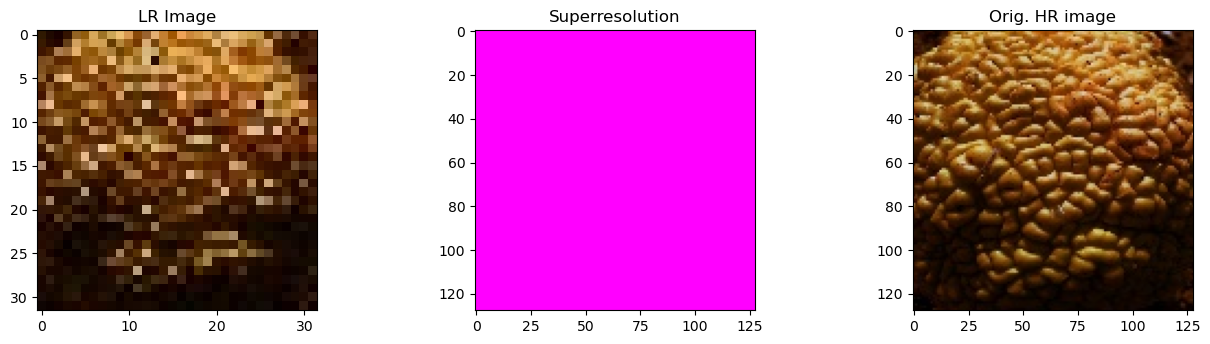

In [78]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [72]:
import cv2

1/1 [==============================] - 0s 70ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


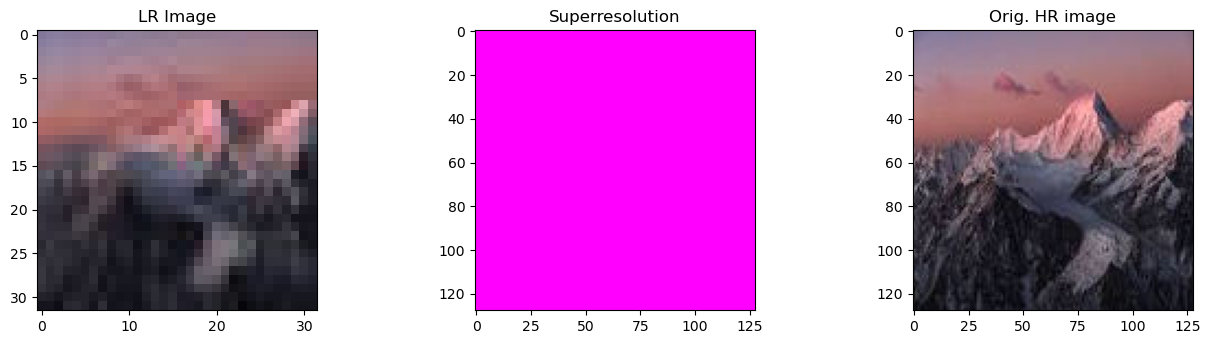

In [73]:
sreeni_lr = cv2.imread("test_lr.jpg")
sreeni_hr = cv2.imread("test_hr.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()